In [1]:
using Revise
includet("../../scripts/single_influx.jl")

In [30]:
using Base.Threads, OhMyThreads
using ProgressMeter
using BenchmarkTools
using JLD2
using Geppetto
using DataFrames
using DataFramesMeta

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Doing exactly Kabirs setup

In [113]:
N = 10
M = N

Ks = 10 .^ range(0., 3., 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
kmax, numks = 50, 1000

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=1.,
        # linflux=1.,
        linflux=Beta(10.,0.01),
        # linflux=Beta(0.5,0.5),
        cinflux=1.,
        
        # rest of the network
        prob_eating=0.1,
        # l=Beta(0.5, 0.5),
        l=0.,
        c=1.,

        # rest
        num_byproducts=4, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, 50., 1000;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        # maxresidthr=1e-10,
        doextinctls=true,
        maxiters=1e5,
        timelimit=10,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress:  48%|███████████████████▌                     |  ETA: 0:00:09┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


countmap(df.sscode) = Dict(2 => 157, -1004 => 1, 1 => 262)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 1, 22 => 9, 2 => 124, 11 => 1, 12 => 1, 1 => 256, 23 => 28)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9047619047619048


0.9047619047619048

In [173]:
probsdf = DataFrame(;
    K=Float64[],
    num_runs=Int[],
    bad_ss=Float64[],
    extinct=Float64[],
    good_ss_bad_ls=Float64[],
    nonext_stable=Float64[],
    nonext_unstable=Float64[],
)
for x in groupby(df, :K)
    K = x.K[1]
    num_runs = nrow(x)
    
    bad_ss = 0
    extinct = 0
    good_ss_bad_ls = 0
    nonext_stable = 0
    nonext_unstable = 0
    for r in eachrow(x)
        if r.sscode == 1
            if r.lscode == 1
                nonext_stable += 1
            elseif r.lscode == 2
                nonext_unstable += 1
            else
                good_ss_bad_ls += 1
            end
        elseif r.sscode == 2
            extinct += 1
        else
            bad_ss += 1
        end
    end
    push!(probsdf, (
        K, num_runs,
        bad_ss / num_runs,
        extinct / num_runs,
        good_ss_bad_ls / num_runs,
        nonext_stable / num_runs,
        nonext_unstable / num_runs,
    ))
end

In [175]:
probsdf

Row,K,num_runs,bad_ss,extinct,good_ss_bad_ls,nonext_stable,nonext_unstable
,Float64,Int64,Float64,Float64,Float64,Float64,Float64
1,1.0,20,0.0,1.0,0.0,0.0,0.0
2,1.41254,20,0.0,1.0,0.0,0.0,0.0
3,1.99526,20,0.0,1.0,0.0,0.0,0.0
4,2.81838,20,0.0,1.0,0.0,0.0,0.0
5,3.98107,20,0.0,1.0,0.0,0.0,0.0
6,5.62341,20,0.0,1.0,0.0,0.0,0.0
7,7.94328,20,0.0,0.85,0.05,0.0,0.1
8,11.2202,20,0.0,0.6,0.0,0.0,0.4
9,15.8489,20,0.0,0.25,0.05,0.0,0.7


In [ ]:
bad_ss
extint
good_ss_bad_ls
good_ss_nonext_stable
good_ss_nonext_unstable

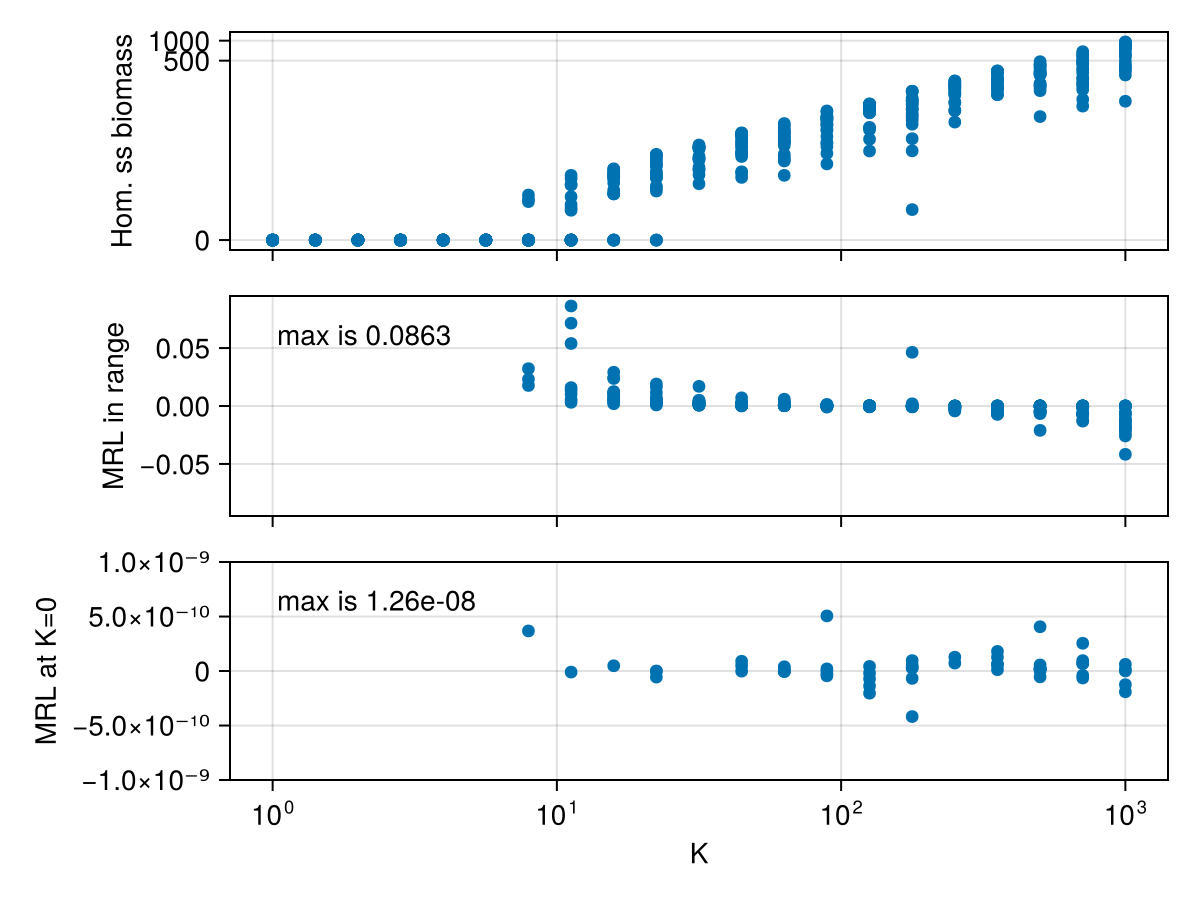

In [159]:
f = Figure(;
    # size=(800, 500)
)

ax_biom = Axis(f[1,1];
    ylabel="Hom. ss biomass",
    yscale=Makie.pseudolog10,
    # yscale=Makie.log10,
    xscale=log10,
)
ax2 = Axis(f[2,1];
    ylabel="MRL in range",
    xscale=log10,
)
ax3 = Axis(f[3,1];
    ylabel="MRL at K=0",
    xscale=log10,
)
linkxaxes!(ax_biom, ax3)
linkxaxes!(ax2, ax3)
for ax in [ax_biom, ax2]
    hidexdecorations!(ax;
        grid=false,
        ticks=false,
    )
end
ax3.xlabel = "K"

xx = @subset df :good_ss
# scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
scatter!(ax_biom, xx.K, xx.hss_biomass)

scatter!(ax2, xx.K, xx.maxmrl)
maxmaxmrl = maximum(xx.maxmrl)
ylims!(ax2, (-1.1, 1.1) .* maxmaxmrl)
text!(ax2, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maxmaxmrl),
    space=:relative,
)

scatter!(ax3, xx.K, xx.k0mrl)
text!(ax3, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maximum(xx.k0mrl)),
    space=:relative,
)
ylims!(ax3, (-1, 1) .* 1e-9)

# display(GLMakie.Screen(), f)

f

# Doing exactly Kabirs setup

In [113]:
N = 10
M = N

Ks = 10 .^ range(0., 3., 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
kmax, numks = 50, 1000

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=1.,
        # linflux=1.,
        linflux=Beta(10.,0.01),
        # linflux=Beta(0.5,0.5),
        cinflux=1.,
        
        # rest of the network
        prob_eating=0.1,
        # l=Beta(0.5, 0.5),
        l=0.,
        c=1.,

        # rest
        num_byproducts=4, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, 50., 1000;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        # maxresidthr=1e-10,
        doextinctls=true,
        maxiters=1e5,
        timelimit=10,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress:  48%|███████████████████▌                     |  ETA: 0:00:09┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


countmap(df.sscode) = Dict(2 => 157, -1004 => 1, 1 => 262)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 1, 22 => 9, 2 => 124, 11 => 1, 12 => 1, 1 => 256, 23 => 28)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9047619047619048


0.9047619047619048

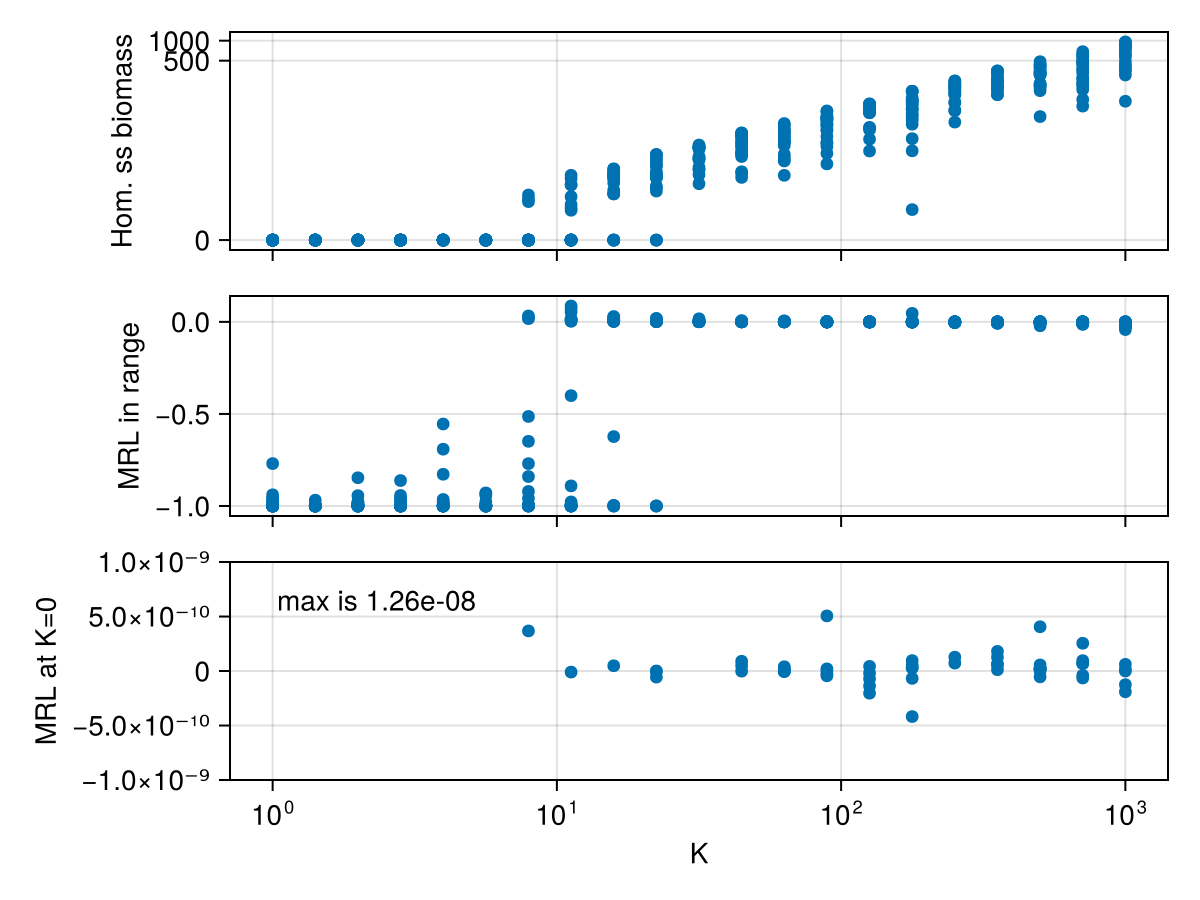

In [150]:
f = Figure()

ax_biom = Axis(f[1,1];
    ylabel="Hom. ss biomass",
    yscale=Makie.pseudolog10,
    # yscale=Makie.log10,
    xscale=log10,
)
ax2 = Axis(f[2,1];
    ylabel="MRL in range",
    xscale=log10,
)
ax3 = Axis(f[3,1];
    ylabel="MRL at K=0",
    xscale=log10,
)
linkxaxes!(ax_biom, ax3)
linkxaxes!(ax2, ax3)
for ax in [ax_biom, ax2]
    hidexdecorations!(ax;
        grid=false,
        ticks=false,
    )
end
ax3.xlabel = "K"

xx = @subset df :good_ss
# scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
scatter!(ax_biom, xx.K, xx.hss_biomass)
scatter!(ax2, xx.K, xx.maxmrl)
scatter!(ax3, xx.K, xx.k0mrl)
text!(ax3, 0.05, 0.75;
    text=(@sprintf "\nmax is %.3g" maximum(xx.k0mrl)),
    space=:relative,
)
# ax3.ylabel = ax3.ylabel[] * @sprintf "\nmax is %.3g" maximum(xx.k0mrl)

ylims!(ax3, (-1, 1) .* 1e-9)

# display(GLMakie.Screen(), f)

f

# Testing

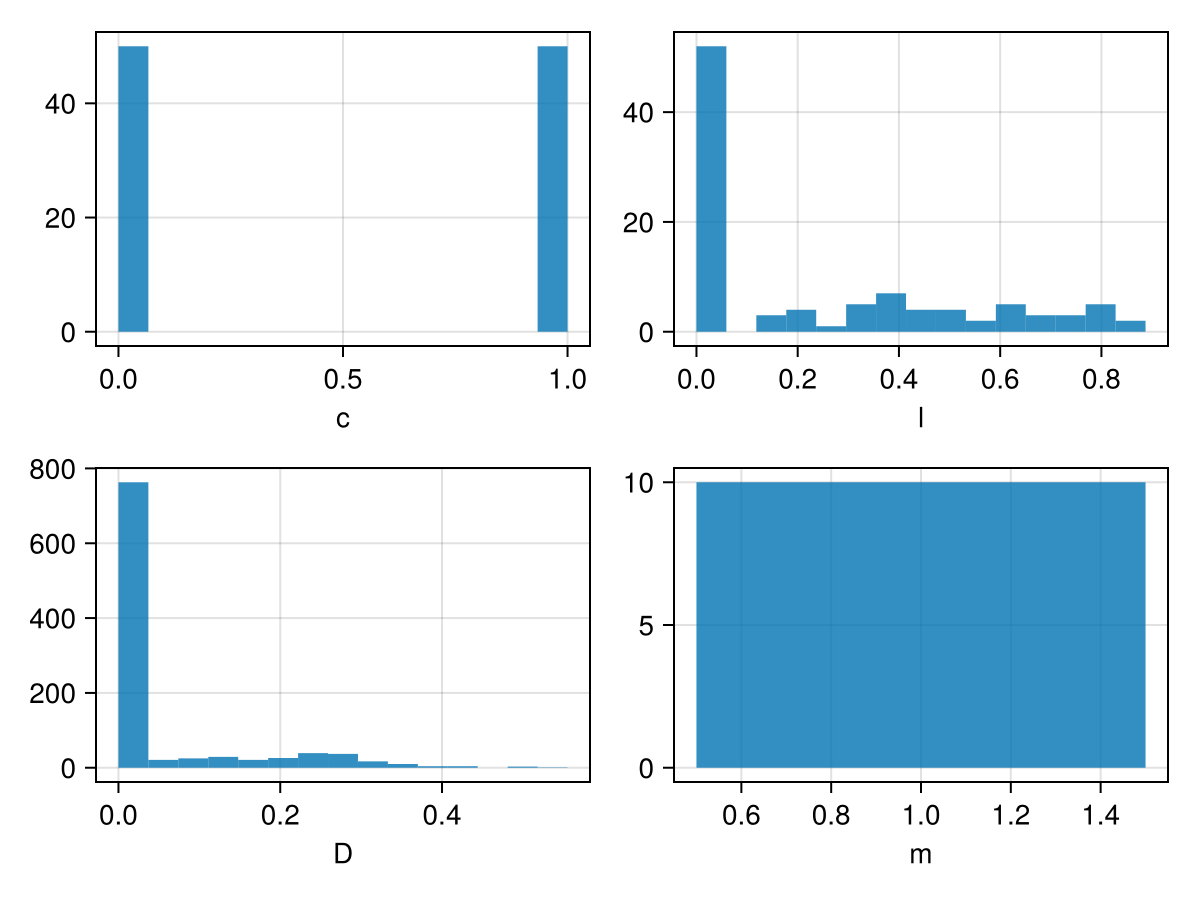

In [7]:
rsg = get_rsg_unimodalc(10;
    K=2,
    # linflux=1.
)

rsg_stats1(rsg)

In [8]:
@time rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

 11.078366 seconds (27.14 M allocations: 5.360 GiB, 3.04% gc time, 1537.87% compilation time: <1% of which was recompilation)


Dict{Int64, Int64} with 2 entries:
  1   => 98
  101 => 2

In [10]:
rsg = JansSampler3(10, 10;
    m=1.,
    K=100.,
    num_influx_resources=1,
    
    prob_eating=0.1,
    num_byproducts=4,
    # l=Beta(0.5, 0.5),
    l=0.,
    c=1.,
    
    prob_eating_influx=1.,
    # linflux=1.,
    linflux=Beta(10.,0.01),
    # linflux=Beta(0.5,0.5),
    cinflux=1.,
)

rsg_stats1(rsg);

In [23]:
instability_stats(cm)

(0.6966292134831461, (0.5946286603942714, 0.7823580914791124))

In [11]:
rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


Dict{Int64, Int64} with 6 entries:
  22    => 8
  101   => 2
  2     => 62
  -1004 => 1
  1     => 25
  23    => 2

# Running a single system

In [56]:
ps = rsg();
# ps = ms();

## No space solver

In [57]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=nothing,
);
maximum(abs, sss.resid)

  9.718093 seconds (13.25 M allocations: 883.607 MiB, 9.12% gc time, 99.28% compilation time)


5.204931152131454e-15

  3.042129 seconds (3.00 M allocations: 205.264 MiB, 3.35% gc time, 99.89% compilation time)


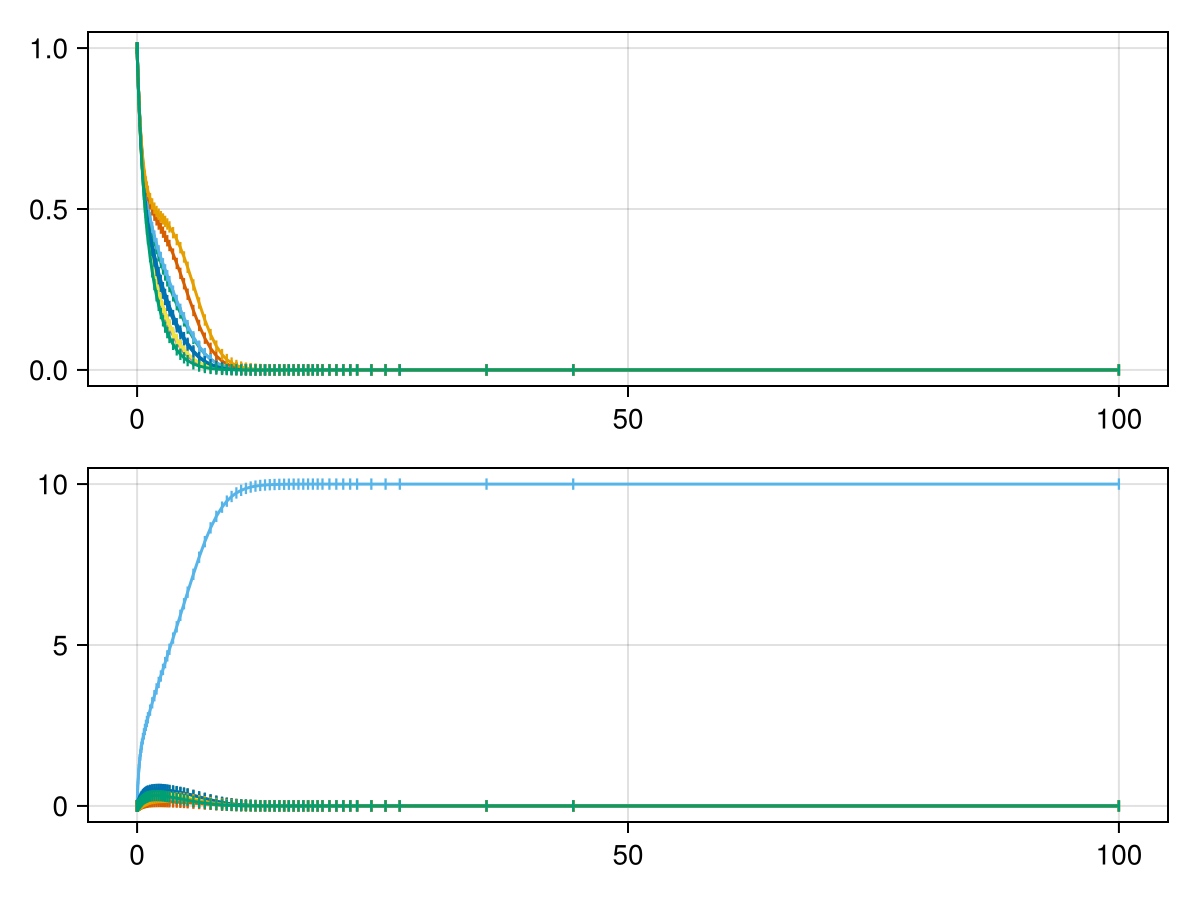

In [58]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 100);
# p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=make_timer_callback(1.)
)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

In [59]:
diagram_sfss_v3(ps, s.u[end];
    strain_threshold=1e-3,
    colorscale=identity,
)

"No strains are above the threshold and so cannot build a diagram"

## Spatial stuff

In [8]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 7.72412788068188e-16


### Linear stability

In [9]:
ks = LinRange(0., 50., 10000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-0.0001574065696420509

In [10]:
xx = LinstabScanTester2(ps, 50., 1000)
xx(ps, nssol)

(1, -0.08450047161454283, -0.0001574065696420509, false)

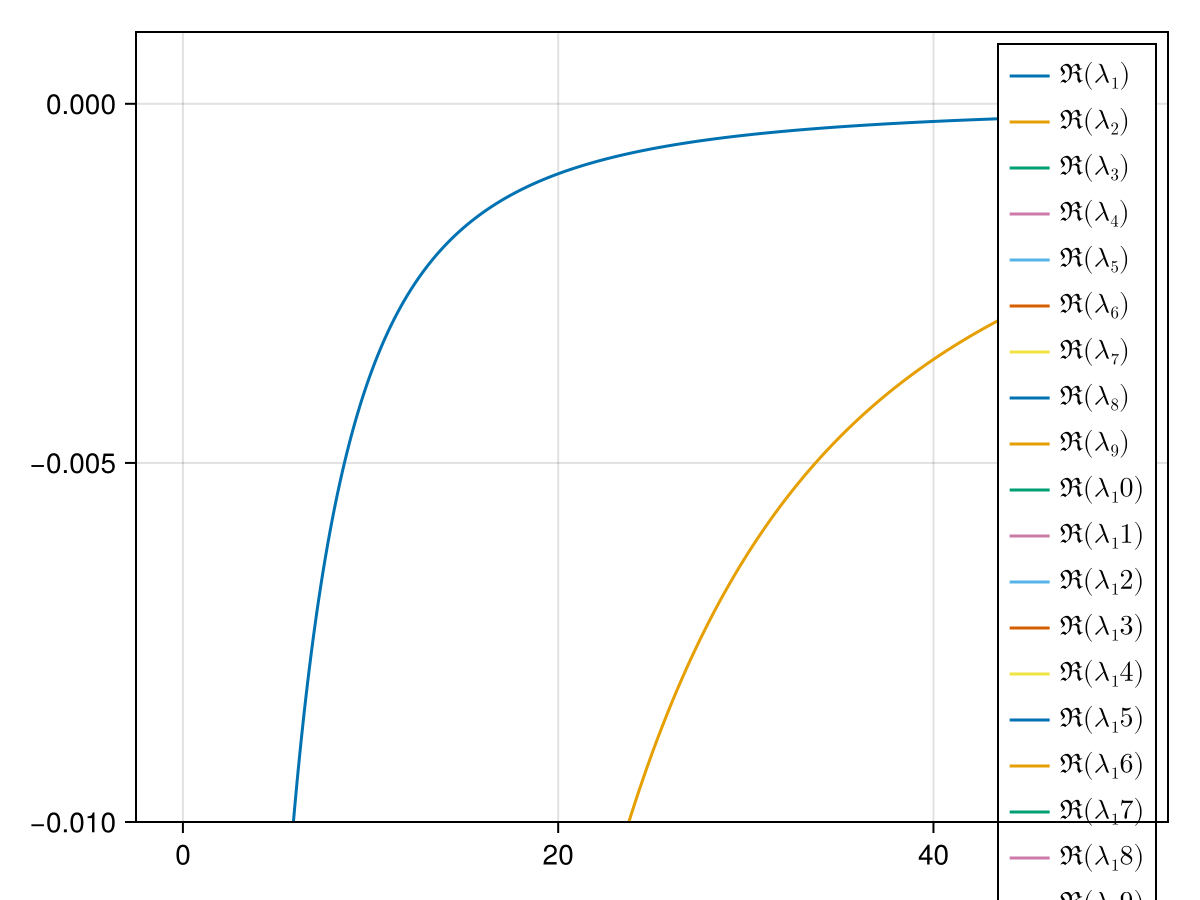

In [11]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


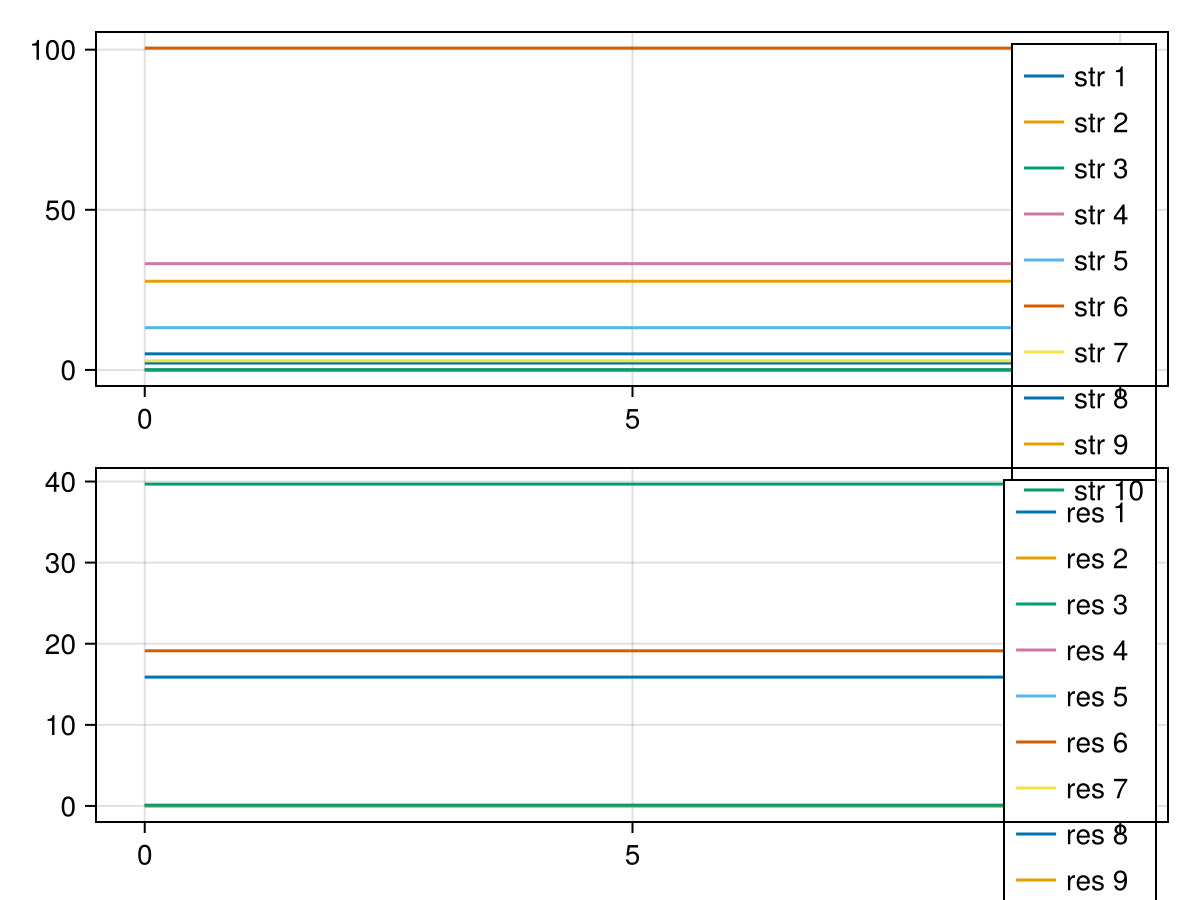

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

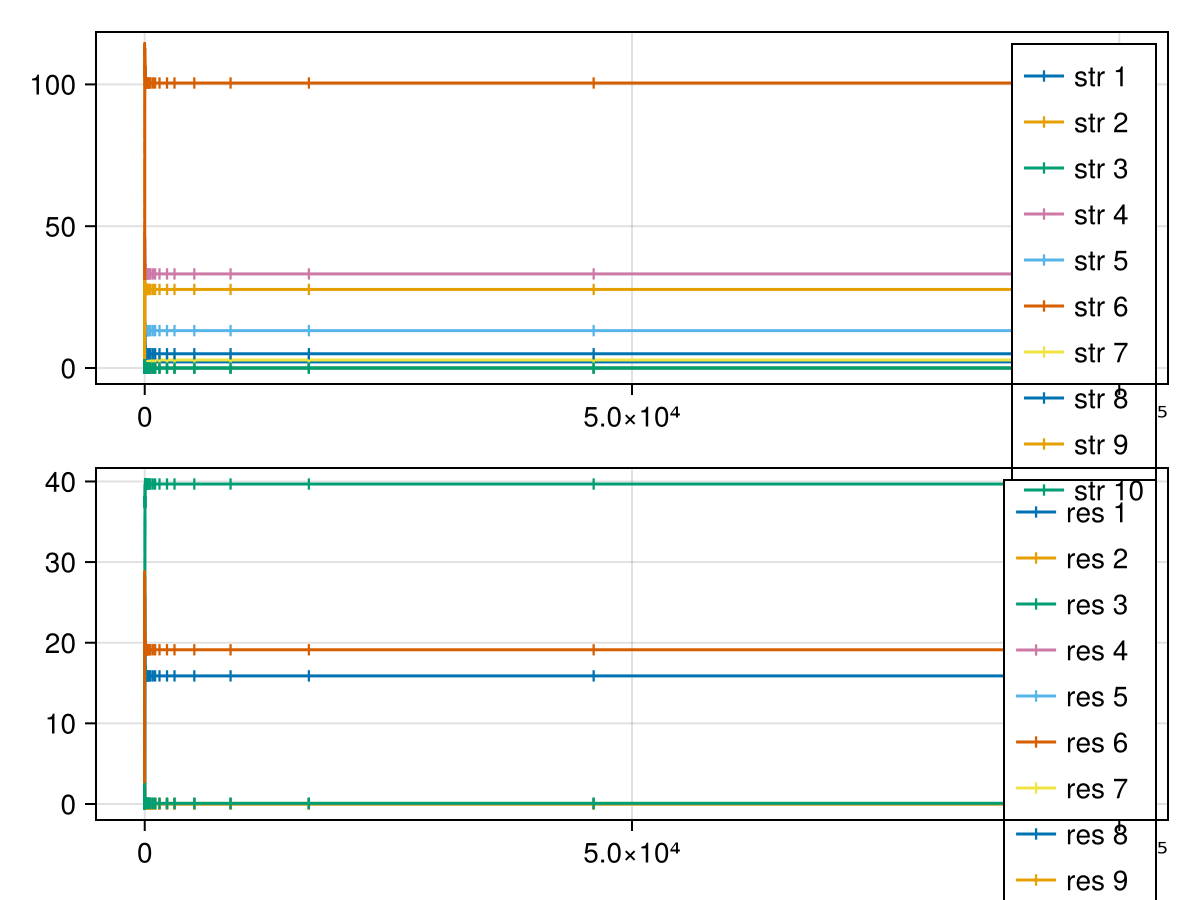

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()